# Audio UX

Task mAIstro supports voice interactions using:
- [OpenAI's Whisper](https://platform.openai.com/docs/guides/speech-to-text) for speech-to-text
- [ElevenLabs](https://github.com/elevenlabs/elevenlabs-python) for text-to-speech

### Install dependencies

Ensure you have `ffmpeg` installed for using ElevenLabs. 

On MacOS, you can install it with `brew install ffmpeg`. 

In [7]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph langchain_core sounddevice scipy elevenlabs sounddevice langchain-community pdfminer
%pip list

In [43]:
%pip install --force-reinstall sounddevice


  Using cached sounddevice-0.5.1-py3-none-any.whl.metadata (1.4 kB)
  Using cached cffi-1.17.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
Using cached sounddevice-0.5.1-py3-none-any.whl (32 kB)
Using cached cffi-1.17.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (446 kB)
Using cached pycparser-2.22-py3-none-any.whl (117 kB)
  Attempting uninstall: pycparser
    Found existing installation: pycparser 2.22
    Uninstalling pycparser-2.22:
      Successfully uninstalled pycparser-2.22
  Attempting uninstall: CFFI
    Found existing installation: cffi 1.17.1
    Uninstalling cffi-1.17.1:
      Successfully uninstalled cffi-1.17.1
  Attempting uninstall: sounddevice
    Found existing installation: sounddevice 0.5.1
    Uninstalling sounddevice-0.5.1:
      Successfully uninstalled sounddevice-0.5.1

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To updat

### Set environment variables

* Set your `OPENAI_API_KEY`
* Set your `ELEVENLABS_API_KEY` (available [here](https://elevenlabs.io/api))
* Optional: Set your `LANGCHAIN_API_KEY` (available [here](https://smith.langchain.com/)) if you want tracing or want to connect with a hosted deployment.

In [8]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGCHAIN_API_KEY")
_set_env("ELEVENLABS_API_KEY")
_set_env("OPENAI_API_KEY")

import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "task-maistro-deployment"

### Connect to your deployment

Connect to your deployment using the URL endpoint:
- **Studio**: Found in Studio UI 
- **CLI**: Printed to console (typically `http://localhost:8123`)
- **Cloud**: Available in LangGraph Deployment page

We'll connect to the deployment as a [RemoteGraph](https://langchain-ai.github.io/langgraph/how-tos/use-remote-graph/#how-to-interact-with-the-deployment-using-remotegraph). 


In [9]:
from langgraph.pregel.remote import RemoteGraph
from langchain_core.messages import convert_to_messages
from langchain_core.messages import HumanMessage, SystemMessage

# Local deployment (via LangGraph Studio)
local_deployment_url = "http://localhost:8123"

# Deployment URL
cloud_deployment_url = "https://task-maistro-1b681add7a2b549499bb0cd21a7e5be4.default.us.langgraph.app"

# Graph name
graph_name = "task_maistro" 

# Connect to the deployment
remote_graph = RemoteGraph(graph_name, url=local_deployment_url)

You can test your deployment by running the following. 

In [4]:
# Int
user_input = "Hi I'm Lance. I live in San Francisco with my wife and have a 1 year old."
config = {"configurable": {"user_id": "Test-Deployment-User"}}
for chunk in remote_graph.stream({"messages": [HumanMessage(content=user_input)]}, stream_mode="values", config=config):
    convert_to_messages(chunk["messages"])[-1].pretty_print()

================================ Human Message =================================

Hi I'm Lance. I live in San Francisco with my wife and have a 1 year old.
================================== Ai Message ==================================

Hello Lance! It's great to meet you. If there's anything specific you'd like to add to your ToDo list or if you have any preferences for managing it, just let me know!


### Add audio

Our deployed graph has some benefits: 
* It has built-in support for long-term memory 
* It implements all the logic for task mAIstro 

But, we have a challenge:
* It takes test as input and returns text as output

We need to add audio input and output to the graph. So, we'll simply add two nodes to our graph:

1. **Audio Input Node**
   * Records microphone input (stop with Enter)
   * Transcribes speech using Whisper
   * Passes text to Task mAIstro

2. **Audio Output Node**
   * Takes Task mAIstro's text response
   * Converts to speech via ElevenLabs
   * Plays audio response

We can achieve this by embedding our deployed graph [as a node](https://langchain-ai.github.io/langgraph/how-tos/use-remote-graph/#using-as-a-subgraph) in a new graph. 

(1246976, 'PortAudio V19.7.0-devel, revision unknown')
   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
*  1 Micrófono (Realtek(R) Audio), MME (2 in, 0 out)
   2 Varios micrófonos (Intel® Smart, MME (4 in, 0 out)
   3 Mezcla estéreo (Realtek(R) Audi, MME (2 in, 0 out)
   4 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
   5 EPSON PJ (HD Audio Driver for D, MME (0 in, 2 out)
   6 Altavoces (Realtek(R) Audio), MME (0 in, 2 out)
   7 Auriculares (Realtek(R) Audio), MME (0 in, 2 out)
   8 Controlador primario de captura de sonido, Windows DirectSound (2 in, 0 out)
   9 Micrófono (Realtek(R) Audio), Windows DirectSound (2 in, 0 out)
  10 Varios micrófonos (Intel® Smart Sound Technology for Digital Microphones), Windows DirectSound (4 in, 0 out)
  11 Mezcla estéreo (Realtek(R) Audio), Windows DirectSound (2 in, 0 out)
  12 Controlador primario de sonido, Windows DirectSound (0 in, 2 out)
  13 EPSON PJ (HD Audio Driver for Display Audio), Windows DirectSound (0 in, 2 out)
  14 Altav

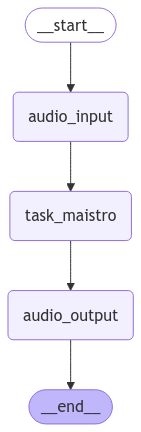

In [10]:
import io
import threading
import numpy as np
import sounddevice as sd
sd._initialize()
print(sd.get_portaudio_version())
print(sd.query_devices())
print(sd.default.device)
sd.default.device = 1

from scipy.io.wavfile import write
from IPython.display import Image, display

from openai import OpenAI

from elevenlabs import play, VoiceSettings
from elevenlabs.client import ElevenLabs

from langgraph.graph import StateGraph, MessagesState, END, START

# Initialize OpenAI client
openai_client = OpenAI()

# Initialize ElevenLabs client
elevenlabs_client = ElevenLabs(api_key=os.getenv("ELEVENLABS_API_KEY"))

def record_audio_until_stop(state: MessagesState):

    """Records audio from the microphone until Enter is pressed, then saves it to a .wav file."""
    
    audio_data = []  # List to store audio chunks
    recording = True  # Flag to control recording
    sample_rate = 16000 # (kHz) Adequate for human voice frequency

    def record_audio():
        """Continuously records audio until the recording flag is set to False."""
        nonlocal audio_data, recording
        with sd.InputStream(samplerate=sample_rate, channels=1, dtype='int16') as stream:
            print("Recording your instruction! ... Press Enter to stop recording.")
            while recording:
                audio_chunk, _ = stream.read(1024)  # Read audio data in chunks
                # print(audio_chunk)
                audio_data.append(audio_chunk)

    def stop_recording():
        """Waits for user input to stop the recording."""
        input()  # Wait for Enter key press
        nonlocal recording
        recording = False

    # Start recording in a separate thread
    recording_thread = threading.Thread(target=record_audio)
    recording_thread.start()

    # Start a thread to listen for the Enter key
    stop_thread = threading.Thread(target=stop_recording)
    stop_thread.start()

    # Wait for both threads to complete
    stop_thread.join()
    recording_thread.join()

    # Stack all audio chunks into a single NumPy array and write to file
    audio_data = np.concatenate(audio_data, axis=0)
    
    # Convert to WAV format in-memory
    audio_bytes = io.BytesIO()
    write(audio_bytes, sample_rate, audio_data)  # Use scipy's write function to save to BytesIO
    audio_bytes.seek(0)  # Go to the start of the BytesIO buffer
    audio_bytes.name = "audio.wav" # Set a filename for the in-memory file
    
    ####

    print('-----', type(audio_bytes), audio_bytes)

    # sd.play(np.concatenate(audio_data, axis=0), samplerate=sample_rate)
    # sd.wait()  # Espera a que se complete la reproducción
    print("Reproducción terminada.")

    ####

    # Transcribe via Whisper
    transcription = openai_client.audio.transcriptions.create(
       model="whisper-1", 
       file=audio_bytes,
    )

    # Print the transcription
    print("Here is the transcription:", transcription.text)

    # Write to messages 
    return {"messages": [HumanMessage(content=transcription.text)]}

def play_audio(state: MessagesState):
    
    """Plays the audio response from the remote graph with ElevenLabs."""

    # Response from the agent 
    response = state['messages'][-1]

    # Prepare text by replacing ** with empty strings
    # These can cause unexpected behavior in ElevenLabs
    cleaned_text = response.content.replace("**", "")
    
    # Call text_to_speech API with turbo model for low latency
    response = elevenlabs_client.text_to_speech.convert(
        voice_id="pNInz6obpgDQGcFmaJgB", # Adam pre-made voice
        output_format="mp3_22050_32",
        text=cleaned_text,
        model_id="eleven_turbo_v2_5", 
        voice_settings=VoiceSettings(
            stability=0.0,
            similarity_boost=1.0,
            style=0.0,
            use_speaker_boost=True,
        ),
    )
    
    # Play the audio back
    play(response)

# Define parent graph
builder = StateGraph(MessagesState)

# Add remote graph directly as a node
builder.add_node("audio_input", record_audio_until_stop)
builder.add_node(graph_name, remote_graph)
builder.add_node("audio_output", play_audio)

builder.add_edge(START, "audio_input")
builder.add_edge("audio_input", graph_name)
builder.add_edge(graph_name,"audio_output")
builder.add_edge("audio_output",END)
graph = builder.compile()

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Optionally, you can supply a thread ID to ensure that conversation history is persisted. 

In [2]:
import uuid
thread_id = str(uuid.uuid4())

Simply, run this cell and speak into your microphone. When you are finished, press Enter.

In [14]:
# Set user ID for stor
# ing memories
# config = {"configurable": {"user_id": "Test-Audio-UX", "thread_id": thread_id}}
# config = {"configurable": {"user_id": "kenny-luque-24534-34534", "thread_id": thread_id}}
config = {"configurable": {"user_id": "diego-24534-34534", "thread_id": thread_id}}

# Kick off the graph, which will record user input until the user presses Enter
for chunk in graph.stream({"messages":HumanMessage(content="Follow the user's instructions:")}, stream_mode="values", config=config):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Follow the user's instructions:
Recording your instruction! ... Press Enter to stop recording.
----- <class '_io.BytesIO'> <_io.BytesIO object at 0x00000235F831FAB0>
Reproducción terminada.
Here is the transcription: Quisiera que me digas mi nombre y me des un resumen de todas las tareas que te he dado.
================================ Human Message =================================

Quisiera que me digas mi nombre y me des un resumen de todas las tareas que te he dado.
================================== Ai Message ==================================

Tu nombre es Diego. Aquí tienes un resumen de todas las tareas que has agregado:

1. **Ir a jugar fútbol a las 14:00** - Estado: No iniciado, Tiempo estimado: 120 minutos.
2. **Ir a jugar fútbol a las 18:00** - Estado: No iniciado, Tiempo estimado: 120 minutos.
3. **Recordatorio de alarma a las 8 de la mañana** - Estado: No iniciado, Tiempo estimado: 5 minuto

## ADD IMAGE

In [17]:
%pip install -U langchain-community langchain_google_genai vertexai langchain-openai
# %pip install --upgrade pip
# %pip list

Note: you may need to restart the kernel to use updated packages.


In [52]:
images = [
    'https://storage.cloud.google.com/gen-ai-devfest/tasks.jpg'
]

from vertexai.generative_models import GenerativeModel, Part

image_file1 = Part.from_uri(
    "gs://gen-ai-devfest/tasks.jpg",
    mime_type="image/jpeg",
)
print(image_file1)

file_data {
  mime_type: "image/jpeg"
  file_uri: "gs://gen-ai-devfest/tasks.jpg"
}



In [32]:
# import vertexai
# vertexai.init(project="generative-ai-442719", location="us-central1")
model = GenerativeModel("gemini-1.5-flash")
response = model.generate_content(
    [
        image_file1,
        "What is shown in this image? respon in spanish",
    ]
)
print(response.text)

La imagen muestra una lista de tareas en español con un botón para agregar más tareas. Las tareas son: "Ir a la compra", "Hacer ejercicio" e "Ir al cumpleaños de Julián". Las tareas completadas están marcadas con una casilla de verificación. Cada tarea tiene un botón "Eliminar" que se puede usar para eliminar la tarea de la lista.


### Integrate Graph

(1246976, 'PortAudio V19.7.0-devel, revision unknown')
   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
*  1 Micrófono (Realtek(R) Audio), MME (2 in, 0 out)
   2 Varios micrófonos (Intel® Smart, MME (4 in, 0 out)
   3 Mezcla estéreo (Realtek(R) Audi, MME (2 in, 0 out)
   4 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
   5 Auriculares (Logi Z607 Stereo), MME (0 in, 2 out)
   6 Altavoces (Realtek(R) Audio), MME (0 in, 2 out)
   7 Auriculares (Realtek(R) Audio), MME (0 in, 2 out)
   8 Controlador primario de captura de sonido, Windows DirectSound (2 in, 0 out)
   9 Micrófono (Realtek(R) Audio), Windows DirectSound (2 in, 0 out)
  10 Varios micrófonos (Intel® Smart Sound Technology for Digital Microphones), Windows DirectSound (4 in, 0 out)
  11 Mezcla estéreo (Realtek(R) Audio), Windows DirectSound (2 in, 0 out)
  12 Controlador primario de sonido, Windows DirectSound (0 in, 2 out)
  13 Auriculares (Logi Z607 Stereo), Windows DirectSound (0 in, 2 out)
  14 Altavoces (Realtek(R

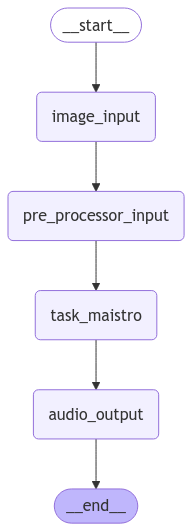

In [30]:
import os
import io
import threading
import sounddevice as sd
sd._initialize()
print(sd.get_portaudio_version())
print(sd.query_devices())
print(sd.default.device)
sd.default.device = 1

from IPython.display import Image, display

from openai import OpenAI

from elevenlabs import play, VoiceSettings
from elevenlabs.client import ElevenLabs

from langgraph.graph import StateGraph, MessagesState, END, START
from langchain_openai import ChatOpenAI
# Initialize OpenAI client
openai_client = OpenAI()

# Initialize ElevenLabs client
elevenlabs_client = ElevenLabs(api_key=os.getenv("ELEVENLABS_API_KEY"))


import numpy as np
from scipy.signal import butter, lfilter
from scipy.io.wavfile import write

is_recording = True  # Estado de la grabación
audio_data_global = []  # Lista para almacenar los chunks de audio grabados
silence_duration = 0  # Contador de tiempo de silencio

from vertexai.generative_models import GenerativeModel, Part

def UploadImageDescription(state: MessagesState):
    image_prompt = """Given an image as input, analyze and describe its content with a focus on recording a task. Extract specific information and structure your response to populate the following fields:

1. task: Briefly describe the main task represented in the image.
2. time_to_complete: Estimate the time required to complete the task in hours or minutes.
3. deadline: If the image suggests a deadline or urgency, provide a reasonable deadline for completing the task. Use the DD-MM-YYYY format for dates.
4. solutions: List possible steps, materials, or approaches needed to complete the task.
5. status: Determine whether the task appears to be pending, in progress, or completed based on the elements in the image.

If the image does not contain enough information to determine a specific field, respond with 'N/A' for that field. Use clear and formal language."""


    image_file1 = Part.from_uri(
        "gs://gen-ai-devfest/tasks.jpg",
        mime_type="image/jpeg",
    )

    model = GenerativeModel("gemini-1.5-flash")
    response = model.generate_content(
        [
            image_file1,
            image_prompt
        ]
    )
    # print(response.text)


    # Write to messages 
    return {"messages": [HumanMessage(content=response.text)]}

def preProcessorInput(state: MessagesState):
    
    # Configuración de grabación
    SAMPLE_RATE = 44100  # Frecuencia de muestreo
    CHUNK_DURATION = 0.5  # Duración de cada chunk en segundos
    SILENCE_THRESHOLD = 0.01  # Umbral RMS para silencio
    SILENCE_TIME = 3  # Segundos de silencio para detener la grabación

    # Variables globales
    

    def stop_recording():
        """
        Función para detener la grabación si se detectan 3 segundos de silencio.
        """
        global is_recording, silence_duration
        while is_recording:
            if silence_duration >= SILENCE_TIME:
                print("Silencio detectado durante 3 segundos. Deteniendo la grabación...")
                is_recording = False
                break

    def record_audio():
        """
        Función para grabar audio y detectar silencio.
        """
        global is_recording, silence_duration, audio_data_global

        def callback(indata, frames, time, status):
            global silence_duration
            if not is_recording:
                raise sd.CallbackStop

            # Calcular RMS (energía del audio)
            rms = np.sqrt(np.mean(indata**2))
            
            # Detectar silencio
            if rms < SILENCE_THRESHOLD:
                silence_duration += CHUNK_DURATION
                print(f"Silencio detectado: {silence_duration:.1f} segundos (RMS={rms:.5f})")
            else:
                silence_duration = 0
                print(f"Audio detectado: RMS={rms:.5f}")

            # Guardar el chunk de audio
            audio_data_global.append(indata.copy())

        print("Iniciando grabación...")
        with sd.InputStream(samplerate=SAMPLE_RATE, channels=1, callback=callback, blocksize=int(SAMPLE_RATE * CHUNK_DURATION)):
            while is_recording:
                pass
        print("Grabación finalizada.")

    # Crear hilos para grabación y detección de silencio
    recording_thread = threading.Thread(target=record_audio)
    stop_thread = threading.Thread(target=stop_recording)

    # Iniciar hilos
    recording_thread.start()
    stop_thread.start()

    # Esperar a que ambos hilos terminen
    stop_thread.join()
    recording_thread.join()

    # Combinar los chunks de audio y convertir a un array NumPy
    audio_data_global_ = np.concatenate(audio_data_global, axis=0)

    # Guardar el audio en formato WAV en un buffer de BytesIO
    audio_bytes = io.BytesIO()
    write(audio_bytes, SAMPLE_RATE, (audio_data_global_ * 32767).astype(np.int16))  # Escalar a 16 bits
    audio_bytes.seek(0)  # Ir al inicio del buffer
    audio_bytes.name = "audio.wav"  # Nombrar el archivo en memoria

    # Guardar el archivo en disco (opcional)
    with open("audio.wav", "wb") as f:
        f.write(audio_bytes.read())

    print("Audio guardado como 'audio.wav'.")
    
    # Transcribe via Whisper
    transcription = openai_client.audio.transcriptions.create(
       model="whisper-1", 
       file=audio_bytes,
    )

    return {"messages": [HumanMessage(content=transcription.text)]}

def play_audio(state: MessagesState):
    
    """Plays the audio response from the remote graph with ElevenLabs."""

    # Response from the agent 
    response = state['messages'][-1]

    # Prepare text by replacing ** with empty strings
    # These can cause unexpected behavior in ElevenLabs
    cleaned_text = response.content.replace("**", "")
    
    # Call text_to_speech API with turbo model for low latency
    response = elevenlabs_client.text_to_speech.convert(
        voice_id="pNInz6obpgDQGcFmaJgB", # Adam pre-made voice
        output_format="mp3_22050_32",
        text=cleaned_text,
        model_id="eleven_turbo_v2_5", 
        voice_settings=VoiceSettings(
            stability=0.0,
            similarity_boost=1.0,
            style=0.0,
            use_speaker_boost=True,
        ),
    )
    
    # Play the audio back
    play(response)

# Define parent graph
builder = StateGraph(MessagesState)

# Add remote graph directly as a node
builder.add_node("image_input", UploadImageDescription)
builder.add_node("pre_processor_input", preProcessorInput)
builder.add_node(graph_name, remote_graph)
builder.add_node("audio_output", play_audio)

builder.add_edge(START, "image_input")
builder.add_edge("image_input", "pre_processor_input")
builder.add_edge("pre_processor_input", graph_name)
builder.add_edge(graph_name,"audio_output")
builder.add_edge("audio_output",END)
graph2 = builder.compile()

display(Image(graph2.get_graph(xray=1).draw_mermaid_png()))

In [15]:
import uuid
thread_id = str(uuid.uuid4())

In [ ]:
# Set user ID for storing memories
# config = {"configurable": {"user_id": "Test-Audio-UX", "thread_id": thread_id}}
config = {"configurable": {"user_id": "kenny-luque-24534-34534", "thread_id": thread_id}}

# Kick off the graph, which will record user input until the user presses Enter
for chunk in graph2.stream({"messages":HumanMessage(content="Follow the user's instructions:")}, stream_mode="values", config=config):
    chunk["messages"][-1].pretty_print()

In [33]:
# Set user ID for storing memories
# config = {"configurable": {"user_id": "Test-Audio-UX", "thread_id": thread_id}}
config = {"configurable": {"user_id": "kenny-luque-24534-34534", "thread_id": thread_id}}

# Kick off the graph, which will record user input until the user presses Enter
for chunk in graph.stream({"messages":HumanMessage(content="Follow the user's instructions:")}, stream_mode="values", config=config):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Follow the user's instructions:


Recording your instruction! ... Press Enter to stop recording.
----- <class '_io.BytesIO'> <_io.BytesIO object at 0x0000020B10F1A390>
Reproducción terminada.
Here is the transcription: Oye, si a la tarea de ir al cumpleaños de Julián, ponle la fecha para el día de mañana.
================================ Human Message =================================

Oye, si a la tarea de ir al cumpleaños de Julián, ponle la fecha para el día de mañana.
================================== Ai Message ==================================

He actualizado la fecha de la tarea "Ir al cumpleaños de Julián" para que sea mañana. ¿Hay algo más en lo que te pueda ayudar?
